Import the Libraries and Data

In [113]:
import pickle
import numpy as np
from matplotlib import pyplot as plt

In [114]:
with open("C:\\Users\\Jerem\\Downloads\\train_data_spanish.pkl", 'rb') as span_file:
    span_train_data = pickle.load(span_file)
span_train = [data[1] for data in span_train_data]

with open("C:\\Users\\Jerem\\Downloads\\train_hard_labels_spanish.pkl", 'rb') as span_labels_file:
    span_labels_data = pickle.load(span_labels_file)


span_train_labels = [1 if data[1] == 'YES' else 0 for data in span_labels_data]

In [115]:
# get rid of any sentence under 15 words
train_sents = []
train_labels = []
for sent, label in zip(span_train, span_train_labels):
    sent = sent.strip().split()
    if len(sent) > 15:
        sent = ' '.join(sent)
        train_sents.append(sent)
        train_labels.append(label)

In [116]:
# check the distribution of the data
print(train_labels.count(0))
print(train_labels.count(1))

1231
1564


TF-IDF Functions

In [117]:
def makeVocab(vocab_sents, analyzer, ngram_range, min_count=110):
    print('Making vocab...')
    ngram_counts = {}
    for sent in vocab_sents:
        if analyzer == 'word':
            words = sent.strip().split()
            for n in range(ngram_range[0], ngram_range[1] + 1):
                for i in range(len(words) - n + 1):
                    ngram = ' '.join(words[i:i+n])
                    ngram_counts[ngram] = ngram_counts.get(ngram, 0) + 1
        elif analyzer == 'char':
            chars = sent.strip()
            for n in range(ngram_range[0], ngram_range[1] + 1):
                for i in range(len(chars) - n + 1):
                    ngram = chars[i:i+n]
                    ngram_counts[ngram] = ngram_counts.get(ngram, 0) + 1
    
    vocab = [ngram for ngram, count in ngram_counts.items() if count >= min_count] #remove the ngrams with low counts to reduce sparsity
    print(f'Vocab created with {len(vocab)} n-grams')
    return vocab


def getTermFreq(sent, ngram):
    if not isinstance(sent, list):
        sent = sent.split()
    return sent.count(ngram)/len(sent)

def getTermFreqMatrix(sentences, vocab):
    print('Making TF matrix...')
    matrix = np.zeros((len(sentences), len(vocab)))
    for i, sent in enumerate(sentences):
        if i % 250 == 0:
            print(f'Processed {i}/{len(sentences)}')
        for j, ngram in enumerate(vocab):
            matrix[i, j] = getTermFreq(sent, ngram)
    print(f'Processed {len(sentences)}/{len(sentences)}')
    print('Term Frequency Matrix Created')
    return matrix


def getIDFmatrix(sentences, vocab):
    print('Creating IDF matrix...')
    n_sentences = len(sentences)
    n_vocab = len(vocab)
    
    vocab_matrix = [[word for word in vocab] for i in range(n_sentences)]
    sentences_matrix = [[sentence for i in range(n_vocab)] for sentence in sentences]
    in_sent = [sum([1 for j in range(n_sentences) if vocab_matrix[j][i] in sentences_matrix[i]]) for i in range(n_vocab)]
    idf = [np.log(n_sentences / (1 + count)) for count in in_sent]
    idf_matrix = [[idf[j] for j in range(n_vocab)] for i in range(n_sentences)]

    print('IDF matrix created')
    return idf_matrix



def TfIDF(sentences, analyzer, ngram_range):
    vocab = makeVocab(sentences, analyzer, ngram_range) # make the vocabulary
    term_freq_matrix = getTermFreqMatrix(sentences, vocab) 
    idf_matrix = getIDFmatrix(sentences, vocab)
    tfidf_matrix = term_freq_matrix * idf_matrix
    print('Complete')
    return tfidf_matrix


In [118]:
tfidf = TfIDF(train_sents, analyzer='char', ngram_range=(2, 3))

Making vocab...
Vocab created with 1236 n-grams
Making TF matrix...
Processed 0/2795
Processed 250/2795
Processed 500/2795
Processed 750/2795
Processed 1000/2795
Processed 1250/2795
Processed 1500/2795
Processed 1750/2795
Processed 2000/2795
Processed 2250/2795
Processed 2500/2795
Processed 2750/2795
Processed 2795/2795
Term Frequency Matrix Created
Creating IDF matrix...
IDF matrix created
Complete


In [119]:
# Checking the shape of the tfidf matrix 
print(tfidf.shape)

(2795, 1236)


Functions

In [120]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def get_accuracy(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    total_predictions = len(y_true)
    accuracy = correct_predictions / total_predictions
    return accuracy

def get_loss(y_true, y_pred): # binary cross entropy loss 
    loss = -1 * np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return loss

def train_neural_network(X, y, num_inputs, num_hidden, num_outputs, num_epochs, learning_rate):

    # randomly initialize the weights
    hidden_weights = np.random.randn(num_inputs, num_hidden)
    output_weights = np.random.randn(num_hidden, num_outputs)
    
    # list to track the losses
    losses = []
    
    for epoch in range(num_epochs):
         # forward pass
        hidden_activations = relu(np.dot(X, hidden_weights))
        output_activations = sigmoid(np.dot(hidden_activations, output_weights))

        # backwards pass
        output_error = y.reshape(-1, num_outputs) - output_activations
        output_gradient = output_error * sigmoid_derivative(output_activations)
        
        hidden_error = np.dot(output_gradient, output_weights.T)
        hidden_gradient = hidden_error * relu_derivative(hidden_activations)

        # updating the weights
        output_weights += learning_rate * np.dot(hidden_activations.T, output_gradient)
        hidden_weights += learning_rate * np.dot(X.T, hidden_gradient)
    
        # calculate and store the loss
        loss = get_loss(y, output_activations)*100 # i am multiplying it by 100 bc I was getting really low numbers which led to divide by zero error
        
        
        # check if the loss is increasing
        if (len(losses) > 10 and loss > losses[epoch-1]) or (len(losses) > 10 and loss < 1) or np.isnan(loss): #only check after ten epochs, check if current loss is greater than previous loss
            print('Stopping early at epoch', epoch)
            break
        else:
            losses.append(loss) # if it is not increasing, save it and print it
            if epoch % 10 == 0:
                print(f'Epoch {epoch} loss: {loss}')

    return hidden_weights, output_weights, losses

def predict(X, hidden_weights, output_weights): # predict on the data to check performance
    hidden_activations = relu(np.dot(X, hidden_weights))
    output_activations = sigmoid(np.dot(hidden_activations, output_weights))
    return np.round(output_activations).flatten()


Train the Neural Network

X shape (2795, 1236)
Labels shape (2795,)
Epoch 0 loss: 134.7108867598705
Epoch 10 loss: 118.31196238871755
Epoch 20 loss: 109.09345077851071
Epoch 30 loss: 103.47997946584255
Epoch 40 loss: 99.10302671648192
Epoch 50 loss: 95.30641240718741
Epoch 60 loss: 92.00135749304836
Epoch 70 loss: 89.11451020182636
Epoch 80 loss: 86.65175585460615
Epoch 90 loss: 84.55974188304356
Epoch 100 loss: 82.78287713732477
Epoch 110 loss: 81.27534022187135
Epoch 120 loss: 79.99660276614738
Epoch 130 loss: 78.92279092702246
Epoch 140 loss: 78.01560890814956
Epoch 150 loss: 77.2572075341973
Epoch 160 loss: 76.61393967692096
Epoch 170 loss: 76.08263129942065
Epoch 180 loss: 75.63847434349914
Epoch 190 loss: 75.26363231482584
Epoch 200 loss: 74.94819263183523
Epoch 210 loss: 74.68326372954273
Epoch 220 loss: 74.46828978014638
Epoch 230 loss: 74.29008670447126
Epoch 240 loss: 74.13922320014977
Epoch 250 loss: 74.01367165413083
Epoch 260 loss: 73.90835359512009
Epoch 270 loss: 73.82027690016268
Epoch 280 loss:

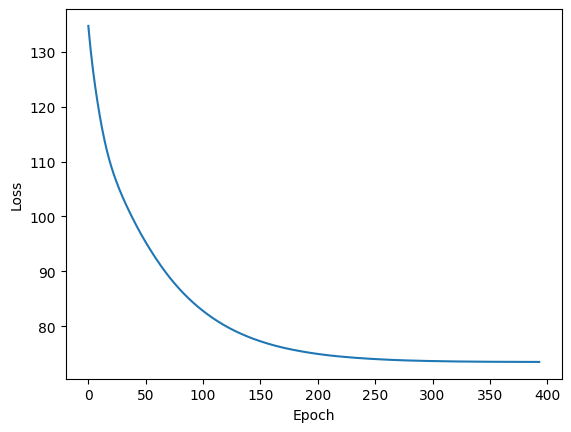

In [121]:
X = tfidf
y = np.array(train_labels)

print('X shape', X.shape)
print('Labels shape', y.shape)

num_inputs = tfidf.shape[1]
num_hidden = 20
num_outputs = 1

hidden_weights, output_weights, losses = train_neural_network(tfidf, y, num_inputs, num_hidden, num_outputs, num_epochs=1000, learning_rate=0.001)


# get the accuracy
predicted_labels = predict(tfidf, hidden_weights, output_weights)

accuracy = get_accuracy(train_labels, predicted_labels)
print('Accuracy:', accuracy)

# plot the loss over epochs
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
